## Expected Goals (xG) Model

In this project we will build an Expected Goals (xG) model using two different supervised learning classification algorithms. We will start with a Logistic Regression as this takes us to the origin of the xG model, and will attempt to beat this benchmark with a more advanced machine learning algorithm. We will use a data set obtained from Statsbomb consisting of all in-match events from every game in the 2018/19 La-Liga football season. 


In brief summary, the Expected Goals model is a newly introduced tool in football analytics that predicts the probability of a given shot resulting in a goal. It has gained increasing attention and popularity among sports scientists, managers, scouts, professional players, and fans alike, acting as a useful modern-day metric for evaluating team and player performance. While the origin of the xG model in football analytics is debatable, many point to the work of Barnett & Hilditch (1993), and more recently Ensum et. al. (2004).

Let's begin by importing the necessary libraries, processing the data, and conducting some exploratory data analysis (EDA).

In [1]:
# Import libraries

# Data processing, manipulation, and mathematical operations
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

# Ignore warning messages generated by python
import warnings
warnings.filterwarnings("ignore")

Now let's import the dataset. For convenience, I have preprocessed most of the data so that it is in a suitable format for our purpose, and carried out some simple feature engineering to generate the distance from goal of each shot, the angle of each shot taken, and the body part used for each shot (i.e. head, foot).

## 1. Data Manipulation & Processing

In [2]:
# Load the data set and store it in the 'df' variable
df = pd.read_csv('la_liga.csv')

# Inspecting the first 5 rows of the dataframe
df.head()

,event_type,id,index,period,timestamp,minute,second,possession,possession_team,play_pattern,...,start_location_x,start_location_y,end_location_x,end_location_y,end_location_z,assisted,x_distance,y_distance,distance,angle
0,shot,53fc97c1-8c2a-43de-bc97-f881c9cfd226,80,1,00:01:26.989,1,26,5,Valencia,From Throw In,...,97.2,52.3,118.1,41.1,2.3,1,22.8,12.3,25.906177,28.345694
1,shot,ac660c63-ce2c-4161-a2b9-8a1759c4acb7,117,1,00:02:05.780,2,5,15,Valencia,Regular Play,...,105.5,39.4,117.8,38.8,0.9,1,14.5,0.6,14.512408,2.369508
2,shot,e166efab-fd48-47bc-89b4-210188266e41,120,1,00:02:07.888,2,7,15,Valencia,From Counter,...,115.3,29.9,120.0,44.0,0.4,0,4.7,10.1,11.140018,65.045249
3,shot,6423db20-7e34-436b-b322-7526512be6ed,376,1,00:07:06.581,7,6,22,Barcelona,From Free Kick,...,94.8,43.6,119.2,42.6,1.0,0,25.2,3.6,25.455844,8.130102
4,shot,25179e55-a58a-4914-b5b8-12bc6ee11b88,455,1,00:08:25.460,8,25,26,Valencia,Regular Play,...,101.8,48.0,120.0,50.1,6.7,1,18.2,8.0,19.880644,23.728391


In [3]:
# Inspecting the information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637 entries, 0 to 1636
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   event_type        1637 non-null   object 
 1   id                1637 non-null   object 
 2   index             1637 non-null   int64  
 3   period            1637 non-null   int64  
 4   timestamp         1637 non-null   object 
 5   minute            1637 non-null   int64  
 6   second            1637 non-null   int64  
 7   possession        1637 non-null   int64  
 8   possession_team   1637 non-null   object 
 9   play_pattern      1637 non-null   object 
 10  off_camera        0 non-null      float64
 11  team              1637 non-null   object 
 12  player            1637 non-null   object 
 13  position          1637 non-null   object 
 14  duration          1637 non-null   float64
 15  under_pressure    261 non-null    object 
 16  statsbomb_xg      1637 non-null   float64


From this output we can see that several of the variables have a high frequency of missing data (NaN's) such as: 'follows_dribble', 'redirect', 'deflected' and 'off_camera'. We will have to address this by either removing variables with a high number of NaNs or using a data processing/manipulation technique while retaining the integrity of the data structure. 

In addition to this, several of the variables in the data set have no relevance or predictive power in our model, such as: 'event_type', 'id', 'index', 'off_camera', 'timestamp', 'possession', etc (In other words, the event id, for example, will have no predictive power when it comes determining the likelihood of a shot resulting in a goal). Let's remove the variables that will not be needed for our model, and create a new dataframe with our set of feature/predictor variables.

In [4]:
# Dropping 'off_camera' from the dataframe as it has 0 observations. 
df = df.drop('off_camera', axis = 1)

In [5]:
# Selecting features from original dataset
features = ['play_pattern', 'position', 'under_pressure', 'body_part', 'type',
           'technique', 'first_time', 'one_on_one', 'open_goal', 'start_location_x',
           'start_location_y', 'end_location_x', 'end_location_y',
           'assisted', 'x_distance', 'y_distance', 'distance', 'angle']

X = df[features]
X.head(3)

,play_pattern,position,under_pressure,body_part,type,technique,first_time,one_on_one,open_goal,start_location_x,start_location_y,end_location_x,end_location_y,assisted,x_distance,y_distance,distance,angle
0,From Throw In,Left Center Midfield,NaN,foot,Open Play,Normal,True,NaN,NaN,97.2,52.3,118.1,41.1,1,22.8,12.3,25.906177,28.345694
1,Regular Play,Left Center Midfield,NaN,foot,Open Play,Normal,True,NaN,NaN,105.5,39.4,117.8,38.8,1,14.5,0.6,14.512408,2.369508
2,From Counter,Left Midfield,NaN,foot,Open Play,Normal,True,NaN,NaN,115.3,29.9,120.0,44.0,0,4.7,10.1,11.140018,65.045249


As we can see from the output above, we have a mix of categorical and continuous variables in our predictor data set. This needs to be transformed and normalised before we can move on to modelling. 

In [6]:
# Identifying categorical features
continuous_feats = X[['start_location_x', 'start_location_y', 'end_location_x', 
                      'end_location_y', 'x_distance', 'y_distance', 'distance', 'angle']]

categorical_feats = ['play_pattern', 'position', 'under_pressure', 'body_part', 'type', 
             'technique', 'first_time', 'one_on_one', 'open_goal', 'assisted']

categorical_feats = X[categorical_feats]

# Import LabelEncoder to encode categorical features into a numeric form
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_feats = categorical_feats.apply(le.fit_transform)

# Concatenating newly-encoded categorical features with existing continuous data
X = pd.concat([categorical_feats, continuous_feats], axis=1)

# Inspecting first few rows of our new dataframe
X.head()

,play_pattern,position,under_pressure,body_part,type,technique,first_time,one_on_one,open_goal,assisted,start_location_x,start_location_y,end_location_x,end_location_y,x_distance,y_distance,distance,angle
0,6,9,0,0,1,4,1,0,0,1,97.2,52.3,118.1,41.1,22.8,12.3,25.906177,28.345694
1,8,9,0,0,1,4,1,0,0,1,105.5,39.4,117.8,38.8,14.5,0.6,14.512408,2.369508
2,1,11,0,0,1,4,1,0,0,0,115.3,29.9,120.0,44.0,4.7,10.1,11.140018,65.045249
3,2,21,0,0,0,4,0,0,0,0,94.8,43.6,119.2,42.6,25.2,3.6,25.455844,8.130102
4,8,9,0,0,1,4,1,0,0,1,101.8,48.0,120.0,50.1,18.2,8.0,19.880644,23.728391


Now that we have preprocessed and transformed our X variables for our xG model, we need to specify our y variable, which is the target variable that we are trying to predict. In this case this is whether a shot results in a goal.

The 'outcome' column of the original dataframe contains a string value for each outcome (or result) of a shot. Examples of these outcomes include: 'Saved', 'Post', 'Blocked', 'Wayward', 'Goal', etc. 

For our xG model we need to predict the likelihood of a goal, given a set of different event data features, so thus we need to create a 'goal' column in our dataframe. To do this, We will create a feature called 'goal' which will contain boolean values (1 or 0), where 1 represents a goal scored and 0 representing no goal.

In [7]:
# Creating the target variable
df['goal'] = np.where(df['outcome'] == 'Goal', 1, 0)

# Target variable
y = df['goal']

## 2. Exploratory Data Analysis

Now that we've organised our data in a format suitable for different machine learning regression models, to get a better understanding of the data that we are working with, let's explore it through EDA and data visualisation techniques.

In [8]:
# Printing goals scored (1) vs no goal (0) from a given shot taken
print('No Goal (0) vs. Goals scored (1) per shot: ')
print('-----------'*4)
print(y.value_counts().to_string())
print('-----------'*4)

# Printing percentage of shots resulting in a goal
goal = np.sum(y == 1)
no_goal = np.sum(y == 0)
print('The percentage of goals scored per shot is: ')
print('-----------'*4)
print('%',np.round(goal/no_goal, 4))

No Goal (0) vs. Goals scored (1) per shot: 
--------------------------------------------
0    1426
1     211
--------------------------------------------
The percentage of goals scored per shot is: 
--------------------------------------------
% 0.148


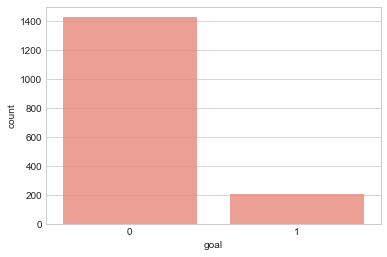

In [9]:
# Visualising goals scored (1) vs no goal (0) from a given shot taken
sns.countplot(df['goal'], color = 'salmon', alpha = 0.85);

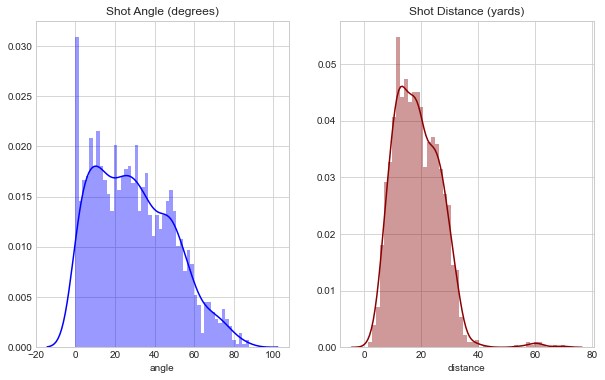

In [10]:
# Plotting the distribution of the angle of each shot taken, and the distance from goal of each shot taken
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,6))
sns.distplot(X['angle'], bins = 50, color = 'blue', ax = ax1)
sns.distplot(X['distance'], bins = 50, color = 'darkred', ax = ax2)
ax1.set_title('Shot Angle (degrees)')
ax2.set_title('Shot Distance (yards)')
plt.show()

Interpreting the Shot Angle and Shot Distance distribution plots above, we can see that most shots are taken with an angle less than 40 degress and from a distance of approximately 10-20 yards. The Shot Angle plot appears to be slightly skewed to the right (right-tail distribution), while the Shot Distance plot appears to resemble a normal distribution (with a few outliers as distance increases). If we wanted to statistically investigate whether these variables are normally distributed, we could use the Shapiro-Wilk Normality test. However, for our purpose of building an expected goals model this is not necessary.

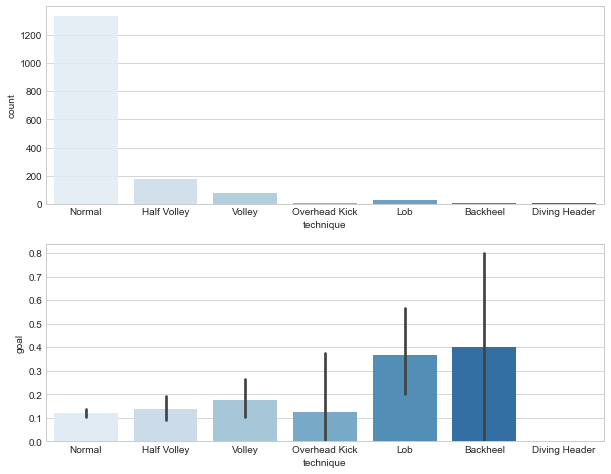

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
ax1 = sns.countplot(df['technique'], palette = "Blues", ax = ax1, alpha = 0.85)
ax2 = sns.barplot(df['technique'], df['goal'], palette = "Blues")

From the first plot, it's clear that a 'normal' technique is more frequently used to take a shot, followed by half-volleys, and volleys. The overhead kick technique (commonly referred to as a bycicle kick) appears to be the least frequent technique used to take a shot, followed by a diving header, and then a backheel. This makes sense intuitively as these techniques are very infrequent in football matches.

We can see from the barplot that backheel, lobbing, and vollying techniques have resulted in the highest frequency of goals scored by percentage. However, this is a misleading statistic due to the small sample size of these shot techniques being taken. 

The vertical black line in the barplot represents the variability of the data and is a graphical measure of the error/uncertainty in each result. From this, we can see that backheel, lob, overhead kick, and volleying have the highest error, whereas a 'normal technique' has the lowest error. This graphically informs us that the 'normal' technique is most likely an accurate representation of the population mean (total goals scored by a normal technique in the population).

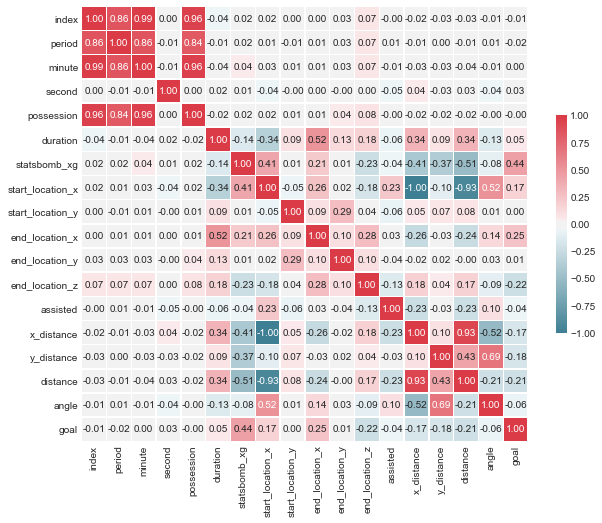

In [12]:
# Creating correlation matrix of variables
corr = df.corr()

# Correlation matrix heatmap
plt.figure(figsize=(10,8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot = True, cmap = cmap, 
            linewidths=0.5, fmt= ".2f",
            cbar_kws={"shrink": .5});

Some notable observations from the correlation matrix/heatmap above:

- 'goal' and 'distance' are negatively correlated, meaning that as the distance from goal increases, the player taking the shot is less likely to score.
- 'goal' and 'start_location_x' are positive correlated, meaning that the closer a player is to the opposition goal when he receives the ball, the higher chance he has of scoring.
- 'goal' and 'angle' are negatively correlated, meaning that as the angle towards the goal face increases, the likelihood of scoring a goal decreases.

## 3. Machine Learning Modelling

In [13]:
# Import libraries for selected ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Data preprocessing and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scikitplot.metrics import confusion_matrix, plot_precision_recall, plot_confusion_matrix, plot_roc_curve

In [14]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Ensuring we have the correct shape for each train and test split
print('Train Set Shape:', X_train.shape, '|', y_train.shape)
print('Test Set Shape:', X_test.shape, '|', y_test.shape)

Train Set Shape: (1145, 18) | (1145,)
Test Set Shape: (492, 18) | (492,)


To finalise the preprocessing step, let's scale our features dataset so that each feature columns is centred at mean 0 and standard deviation 1. This often helps with model performance and accuracy.

In [15]:
# Feature Scaling using Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### 3.1. Logistic Regression

Many of the original xG models that were developed in the early 2000's used Logistic Regression algorithms. For our first Machine Learning model, let's use the Logistic Regression and treat it as the benchmark for algorithm performance. We can then utilise other powerful models to see if we can improve on this initial benchmark. 

The Logistic regression is a classification algorithm that predicts a binary target variable  - in our case 1 for goal scored or 0 for no goal score -  based on one or more predictor variables (independent variables). It uses a logistic function, which is often referred to as a sigmoid function due to its S-shaped curve. Instead of fitting a straight-line (as with linear regressions), the logisitic regression fits a sigmoid function to the data to squeeze the output of the regression between a value of 0 and 1. The logistic (sigmoid) function $g(z): \mathbb{R} \Rightarrow (0,1) $ can be defined as:

$$g(z) = \frac{1}{1 + exp(-z)}$$

As can be seen in the following formula, the predictor variables are enclosed in the logistic function which "squeezes" the output of each predictor variable to either a value of 0 or 1.

$$P(y^{(i)}=1)=\frac{1}{1+exp(-(\beta_{0}+\beta_{1}x^{(i)}_{1}+\ldots+\beta_{k}x^{(i)}_{k}))}$$

Now that we've covered the basics of logistic regression and the sigmoid function, let's create our first benchmark model.

In [16]:
# Logistic Regression
log_r = LogisticRegression(random_state=0)
log_r.fit(X_train, y_train)

# Predicting test set results
log_pred = log_r.predict(X_test)
log_pred_proba = log_r.predict_proba(X_test)

print('Actual goals scored:', sum(y_test))
print('Predicted goals scored:', sum(log_pred))
print('Actual shots missed:', sum(y_test == 0))
print('Predicted shots missed:', sum(log_pred == 0))
print('Predicted expected goals (xG)', round(sum(log_pred_proba[:,1]),2))
print('--'*20)

Actual goals scored: 60
Predicted goals scored: 30
Actual shots missed: 432
Predicted shots missed: 462
Predicted expected goals (xG) 67.94
----------------------------------------


Now let's print the classification report, and plot the confusion matrix, roc-curve and precision-recall curve.

To briefly summarise, the classification report details the performance of the model according to the metrics precision, recall, and the f1-score per class. Precision details the ability of a classifier algorithm to not label a negative occurrence positive (i.e. the accuracy of positive predictions - also known as positive predictive value). It is the ratio of true positives divided by true positives plus false positives per class. Recall is the ability of a classifier to correctly identify all positive occurrences (i.e. ratio of positives correctly identified - also known as sensitivity). The F1 score is a weighted average of precision and recall and it obtains a value between 0 and 1 (where 1 denotes the best performance and 0 the worst).

The ROC reflects the diagnostic ability of a classifier model. It plots the true positive rate (TPR) on the y-axis and the false positive rate (FPR) on the x-axis. The simple intuition behind the ROC curve is that a perfect prediction exists in the upper-most left corner of the plot (TPR = 1 & FPR = 0). This location represents no false positives and no false negatives.

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       432
           1       0.67      0.33      0.44        60

    accuracy                           0.90       492
   macro avg       0.79      0.66      0.69       492
weighted avg       0.88      0.90      0.88       492



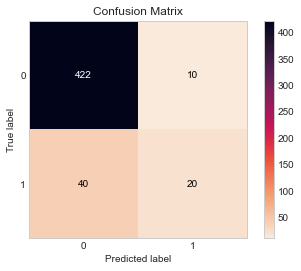

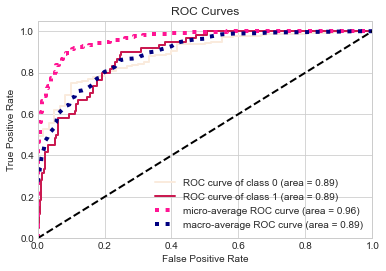

In [17]:
# Evaluating performance of Logistic Regression model
print(classification_report(y_test, log_pred))

# Plotting Confusion Matrix
plot_confusion_matrix(y_test, log_pred, cmap = 'rocket_r')

# Plotting ROC Curve
plot_roc_curve(y_test, log_pred_proba, cmap = 'rocket_r');
# plot_precision_recall(y_test, log_pred_proba, cmap = 'rocket_r');

Evaluating the performance of our Logsitic Regression model:

- We can see that our model has a precision of 0.91 for the no goal prediction class (0) and 0.67 for the goal prediction class (1). The model has a recall of 0.98 for the no goal class and 0.33 for the goal class. This tells us that the model is very good at predicting when a shot not result in a goal, but quite poor at predicting when a shot will result in a goal.
- The model has an accuracy of 0.90, indicating a high percentage of "correct" total classifications (True positives + True negatives / All classifications).

### 3.2. Random Forrest Classifier

For our second model, let's implement a Random Forrest Classification model to try and improve on our benchmark Logistic Regression and see if we can derive a more accurate result. In simple terms, a random forest classifier is an algorithm containing many decision trees. It uses techniques such as feature randomness and bootstrap aggregating (or bagging) to construct and combine each tree into a single uncorrelated forest of trees. In essence, it is an ensemble learning method that takes the best predictive elements from individual trees and aggregates them into a single model.

In [18]:
clf = RandomForestClassifier(n_estimators = 500, n_jobs = 1, random_state = 42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

print('Actual goals scored:', sum(y_test))
print('Predicted goals scored:', sum(y_pred))
print('Actual shots missed:', sum(y_test == 0))
print('Predicted shots missed:', sum(y_pred == 0))
print('Predicted expected goals (xG)', round(sum(y_pred_proba[:,1]),2))

Actual goals scored: 60
Predicted goals scored: 53
Actual shots missed: 432
Predicted shots missed: 439
Predicted expected goals (xG) 63.56


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       432
           1       0.75      0.67      0.71        60

    accuracy                           0.93       492
   macro avg       0.85      0.82      0.84       492
weighted avg       0.93      0.93      0.93       492



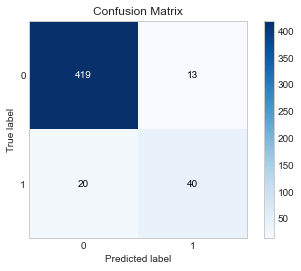

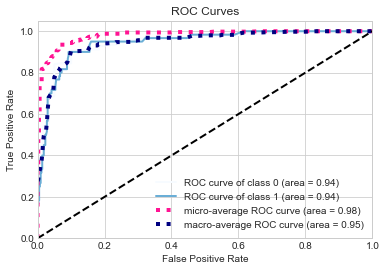

In [19]:
# Evaluating performance of Random Forest Classifier
print(classification_report(y_test, y_pred))

# Plotting Confusion Matrix
plot_confusion_matrix(y_test, y_pred, cmap = 'Blues');

# Plotting ROC Curve, and Precision-Recall Curve
plot_roc_curve(y_test, y_pred_proba, cmap = 'Blues');
# plot_precision_recall(y_test, y_pred_proba, cmap = 'Blues')

Evaluating our Random Forest Classifier's performance:

- The model has a precision of 0.95 for the no goal class (0) and a precision of 0.75 for the goal class (1), and a recall of 0.97 for the no goal class (0) vs a recall of 0.67 for the goal class (1). From this we can tell that the Random Forest classifier is much better at predicting when a goal will actually be scored versus the baseline logistic regression model (recall of 0.67 vs. recall of 0.33).
- The Random Forest classifier has an accuracy score of 0.93 > the Logistic Regression's accuracy of 0.90.

## 4. Hyperparameter Tuning

Now that we've improved on our benchmark Logistic Regression model with a Random Forest Classifier, let's see if we can improve our Random Forest algorithm through hyperparameter tuning. In this section we will pre-define a range of different hyperparameter options to select from, and then iterate through these options with scikit learn's GridSearchCV function.

In [20]:
# Define a dictionary containing range of different parmaters to tune
param_grid = {
    'n_estimators': [50, 100, 200,300,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5,6,7,8],
    'criterion': ['gini', 'entropy']

}

cv_clf = GridSearchCV(clf, param_grid, cv = 4, n_jobs = -1)
cv_clf.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(n_estimators=500, n_jobs=1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300, 500]})

In [21]:
# Printing the best parameters returned by the GridSearch function
print('The best parameters for our model are:')
print('--'*20)
print(pd.Series(cv_clf.best_params_))

The best parameters for our model are:
----------------------------------------
criterion       entropy
max_depth             8
max_features       auto
n_estimators        100
dtype: object


Now let's create our final Random Forest classifier with the optimised hyperparameters and evaluate its performance over our untuned classifier.

In [22]:
# Creating final model with tuned hyperparameters
final_clf = RandomForestClassifier(n_estimators = 100, max_depth = 8,
                            max_features = 'auto', criterion = 'entropy')

# Fitting model to train data set
final_clf.fit(X_train, y_train)

clf_pred = final_clf.predict(X_test)
clf_pred_proba = final_clf.predict_proba(X_test)

print('Actual goals scored:', sum(y_test))
print('Predicted goals scored:', sum(clf_pred))
print('Actual shots missed:', sum(y_test == 0))
print('Predicted shots missed:', sum(clf_pred == 0))
print('Predicted expected goals (xG)', round(sum(clf_pred_proba[:,1]),2))

Actual goals scored: 60
Predicted goals scored: 44
Actual shots missed: 432
Predicted shots missed: 448
Predicted expected goals (xG) 62.82


We can see that our final model predicts 61.87 expected goals, which is only 1.87 goals in difference from the actual goals scored during the 2018/19 La Liga season. It improves on the xG prediction of our first Logistic Regression model which was 67.94, and our baseline Random Forest Classifier which returned an xG prediction of 63.56 goals. 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       432
           1       0.77      0.57      0.65        60

    accuracy                           0.93       492
   macro avg       0.86      0.77      0.81       492
weighted avg       0.92      0.93      0.92       492



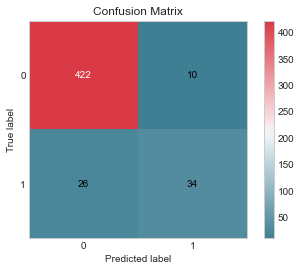

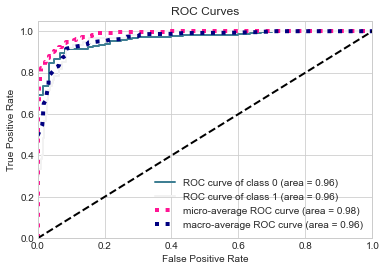

In [23]:
# Evaluating performance of Final Random Forest Classifier model
print(classification_report(y_test, clf_pred))

# Plotting Confusion Matrix
plot_confusion_matrix(y_test, clf_pred, cmap = cmap);

# Plotting ROC Curve, and Precision-Recall Curve
plot_roc_curve(y_test, clf_pred_proba, cmap = cmap);
# plot_precision_recall(y_test, clf_pred_proba, cmap = 'Blues');

Interpreting key findings from our final model's performance:

- The final model correctly predicts 36 goals (True Positive) that were actually goals, but incorrectly predicts 24 goals that were not goals (False Negative). 
- It performs the best in terms of correctly predicting no goal 422 times (True Negative), while only missclassifying 10 shots as goals that did not result in a goal (False Positive).
- The final model has an accuracy of 0.93, which is inline with our first Random Forest classifier - suggesting negligible improvement from hyperparameter tuning.

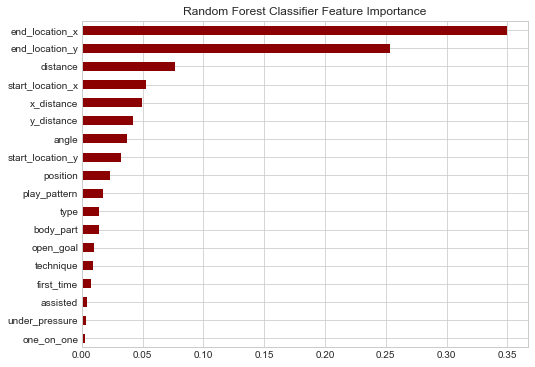

In [24]:
# Extracting the features importances of our final model
feat_importances = pd.Series(final_clf.feature_importances_, index = X.columns)
feat_importances = feat_importances.sort_values()

# Visualising the Random Forest Classifier's feature importances
plt.figure(figsize=(8,6))
feat_importances.plot(kind='barh', color = 'darkred')
plt.title('Random Forest Classifier Feature Importance')
plt.show()

From the plot above, we can see that the features from our data set that best predict whether a goal will be scored or not are:
- end_location_x
- end_location_y
- distance (from goal)

The features that have the least predictive power and have the smallest contribution in our model are:
- one_on_one
- under_pressure
- assisted

It's important to note once again that a feature such as 'one_on_one' may have low predictability in our data set due to the low number of observations for this variable. It is fairly rare for a player to shoot from a one-on-one position so we would need a large sample size to truly evaluate the predictive power of this feature.

In [25]:
# Import pickle to save our final model
import pickle

# Saving our final model for future use and application
with open('RF_Classification_Model', 'wb') as f:
    pickle.dump(final_clf, f)

## 5. Summary

In this Data Science project we have built an optimised machine learning model to predict the probability that a goal is scored from a given shot in a football match. Our final xG model has been tuned to deliver a high performance accuracy on the train and set data set, predicting an expected goals value of 61.87 in relation to the actual goals scored in our test data set which was 60 goals - an absolute margin of error of only ~2 goals. Location and x-coordinate and y-coordinate distance from goal when a shot is taken are the most predictive features in our model. Intuitively this makes sense, due to the fact that a player is much more likely to score when they are closer to the oppositions goal. Our final xG model obtained a highly-accurate f1 score of 0.93, improving on the 0.90 f1 score obtained from the baseline logistic regression model. 

In terms of application, this model or one similar to it could be deployed on a website, app, or internally within a software designed for professional football teams/managers/scouts, or simply as an additional analytic metric for fans (with a consistent stream of match-event data such as that provided by Statsbomb in our example).

This project was inspired by Professor David Sumpter's 'Mathematical Modelling of Football' course in the Masters of applied Mathematics programme at Uppsala University in Sweden (this course is one in which I audited and participated in online). Professor David Sumpter's course is a fantastic learning resource for those interested in the cutting-edge data science research in professional football (from Expected Goals models, Markov Chains applied to passing networks, pitch control analytics and visualisation, and expected possession value to name a few). Here is a link to this course for anyone reading this that is potentially interested: https://uppsala.instructure.com/courses/28112